# Neural Network-Based Failure Analysis for AI4I 2020 Preventive Maintenance

This notebook implements advanced failure prediction and feature importance analysis using a neural network (MLP) for the AI4I 2020 preventive maintenance dataset. The workflow includes:

- Data cleaning and feature engineering (consistent with previous analysis)
- Neural network (MLPClassifier) training and hyperparameter tuning for each failure type
- Evaluation and visualization of model performance
- Feature importance analysis using permutation importance

All code is modular, reproducible, and follows the AI Coding Commandments.

In [1]:
# Imports and Setup for Neural Net Analysis
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import f1_score, precision_recall_curve, classification_report, confusion_matrix, precision_score, recall_score
from sklearn.preprocessing import StandardScaler
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Load the AI4I 2020 dataset
DATA_PATH = '../Preventive Maint/ai4i2020.csv'
df = pd.read_csv(DATA_PATH)

def clean_and_engineer_features(df):
    df = df.copy()
    df = df.drop(columns=[col for col in ['UDI', 'Product ID'] if col in df.columns], errors='ignore')
    if 'Type' in df.columns:
        df = pd.get_dummies(df, columns=['Type'], drop_first=True)
    for col in ['TWF', 'HDF', 'PWF', 'OSF', 'RNF', 'Machine failure']:
        if col in df.columns:
            df[col] = df[col].astype(int)
    return df

df_clean = clean_and_engineer_features(df)
display(df_clean.head())

,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF,Type_L,Type_M
0,298.1,308.6,1551,42.8,0,0,0,0,0,0,0,False,True
1,298.2,308.7,1408,46.3,3,0,0,0,0,0,0,True,False
2,298.1,308.5,1498,49.4,5,0,0,0,0,0,0,True,False
3,298.2,308.6,1433,39.5,7,0,0,0,0,0,0,True,False
4,298.2,308.7,1408,40.0,9,0,0,0,0,0,0,True,False



=== Neural Net Analysis for Machine failure ===
Best Params: {'alpha': 0.01, 'hidden_layer_sizes': (32, 16), 'learning_rate_init': 0.01, 'max_iter': 200}
Best Threshold: 0.352, F1: 0.752, Precision: 0.726, Recall: 0.779
Best Params: {'alpha': 0.01, 'hidden_layer_sizes': (32, 16), 'learning_rate_init': 0.01, 'max_iter': 200}
Best Threshold: 0.352, F1: 0.752, Precision: 0.726, Recall: 0.779


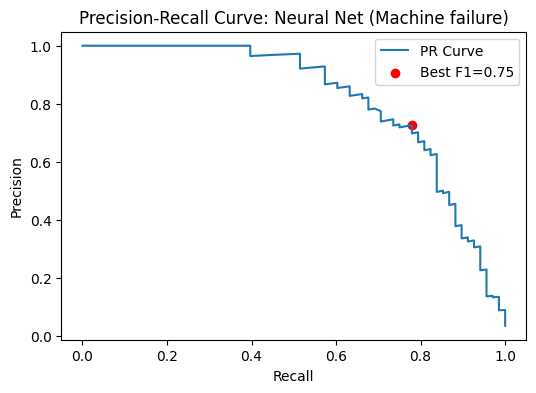

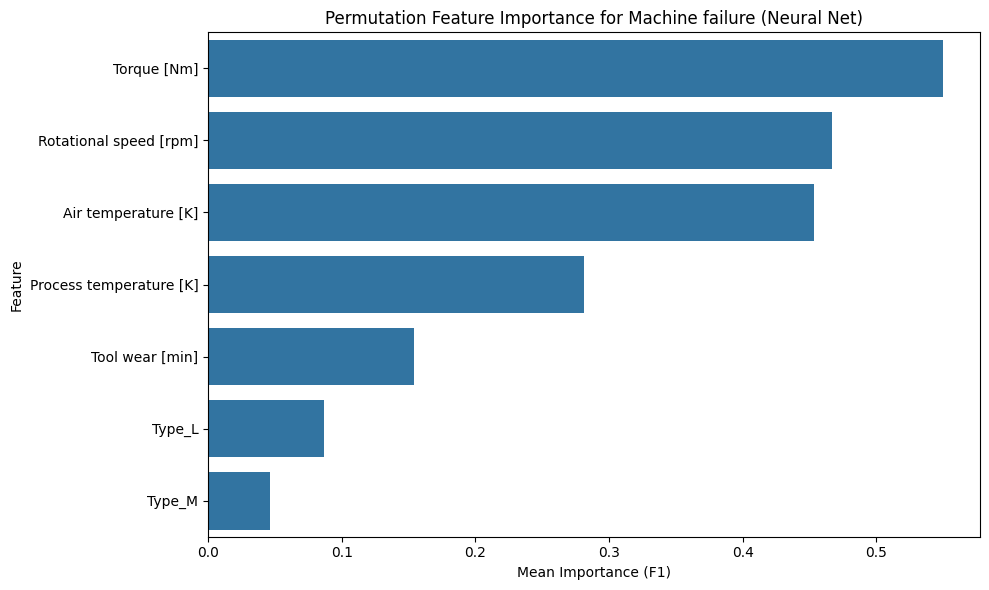


=== Neural Net Analysis for TWF ===
Best Params: {'alpha': 0.001, 'hidden_layer_sizes': (32, 16), 'learning_rate_init': 0.01, 'max_iter': 200}
Best Threshold: 0.114, F1: 0.148, Precision: 0.111, Recall: 0.222
Best Params: {'alpha': 0.001, 'hidden_layer_sizes': (32, 16), 'learning_rate_init': 0.01, 'max_iter': 200}
Best Threshold: 0.114, F1: 0.148, Precision: 0.111, Recall: 0.222


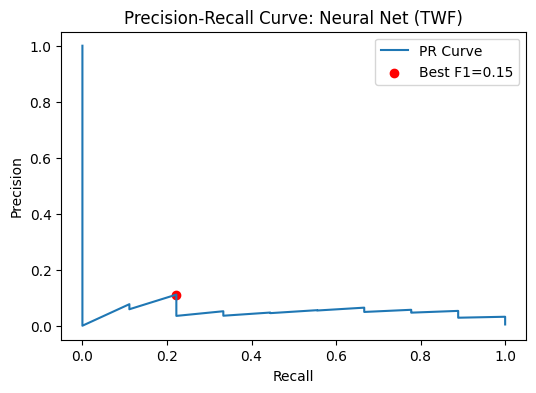

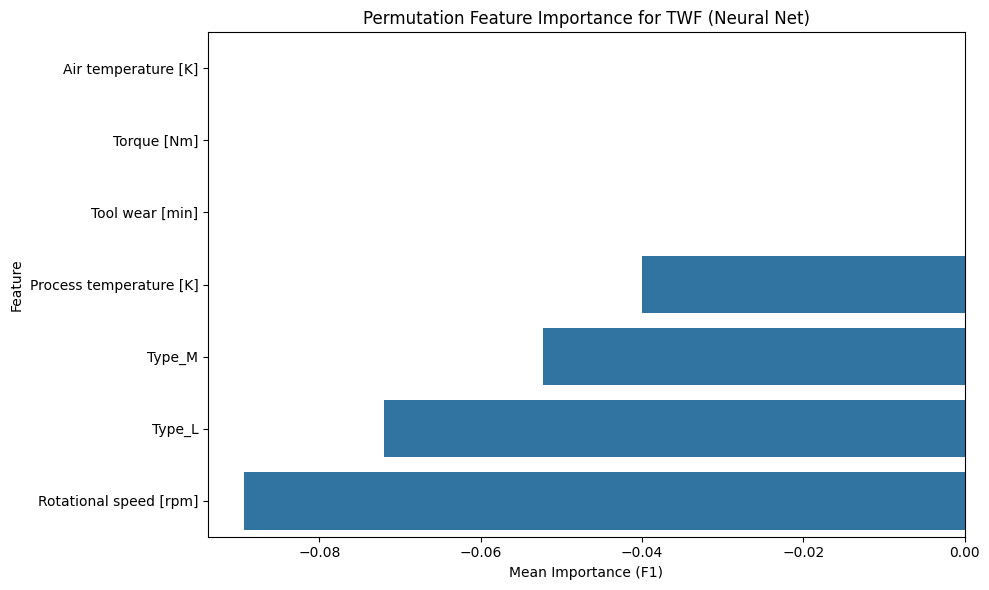


=== Neural Net Analysis for HDF ===
Best Params: {'alpha': 0.001, 'hidden_layer_sizes': (32,), 'learning_rate_init': 0.01, 'max_iter': 200}
Best Threshold: 0.531, F1: 0.878, Precision: 1.000, Recall: 0.783
Best Params: {'alpha': 0.001, 'hidden_layer_sizes': (32,), 'learning_rate_init': 0.01, 'max_iter': 200}
Best Threshold: 0.531, F1: 0.878, Precision: 1.000, Recall: 0.783


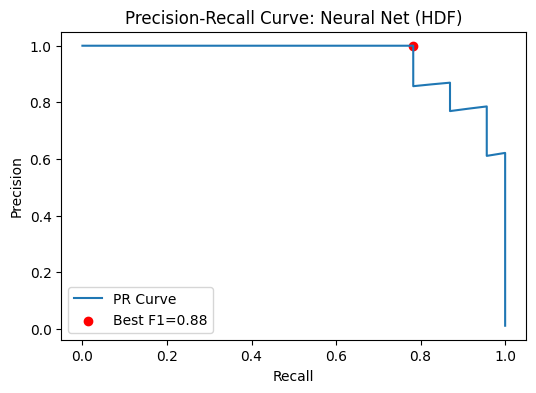

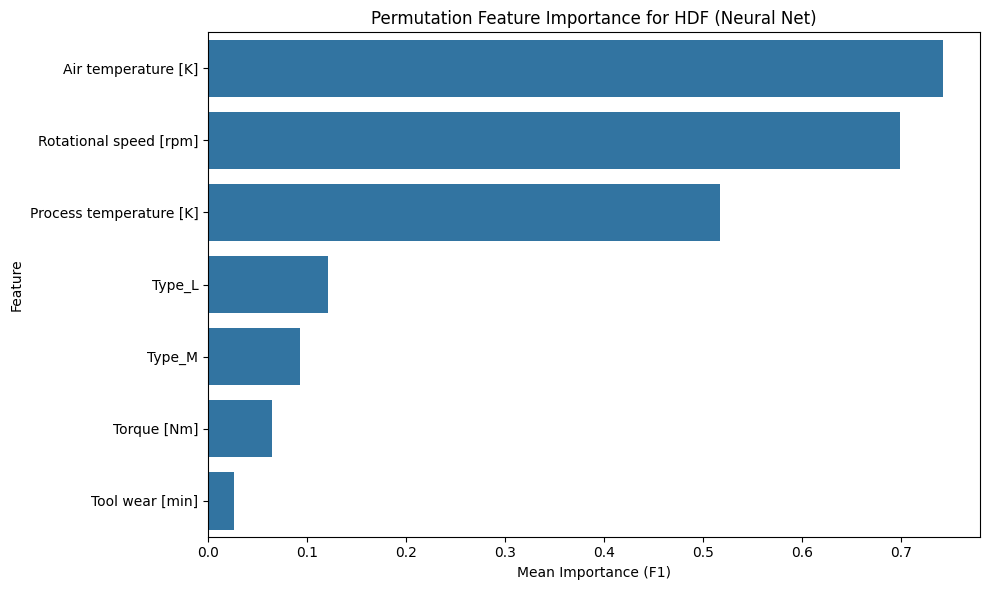


=== Neural Net Analysis for PWF ===
Best Params: {'alpha': 0.0001, 'hidden_layer_sizes': (32,), 'learning_rate_init': 0.01, 'max_iter': 200}
Best Threshold: 0.564, F1: 0.919, Precision: 0.944, Recall: 0.895
Best Params: {'alpha': 0.0001, 'hidden_layer_sizes': (32,), 'learning_rate_init': 0.01, 'max_iter': 200}
Best Threshold: 0.564, F1: 0.919, Precision: 0.944, Recall: 0.895


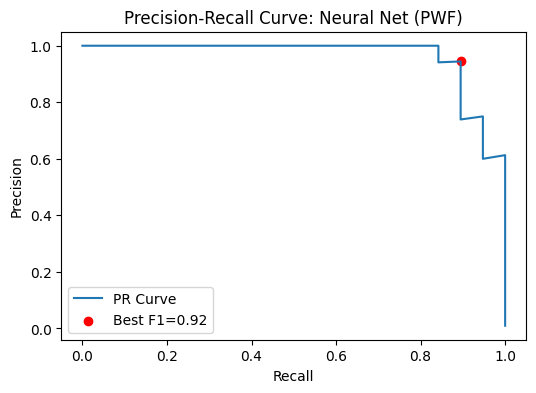

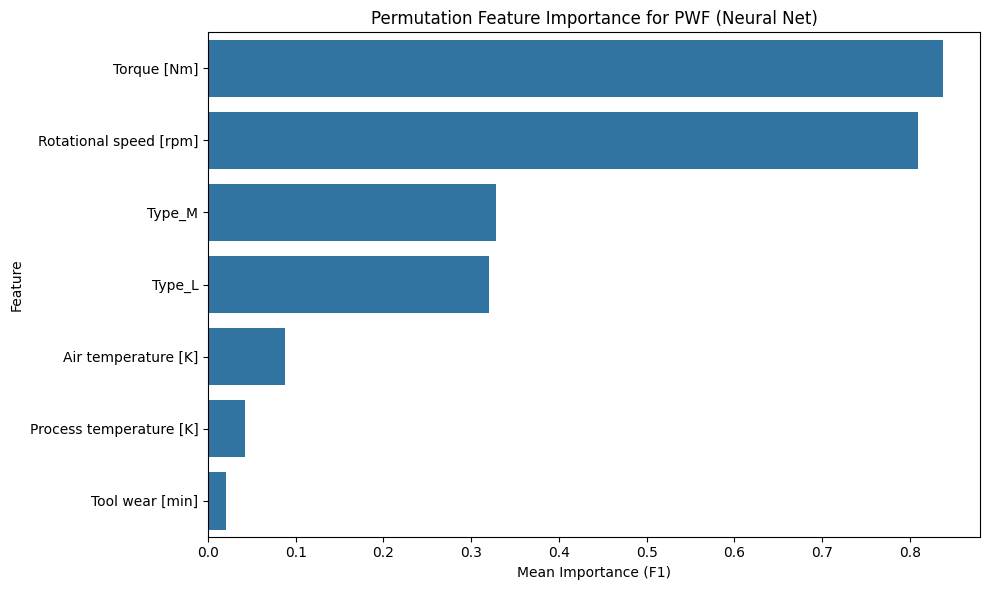


=== Neural Net Analysis for OSF ===
Best Params: {'alpha': 0.01, 'hidden_layer_sizes': (32, 16), 'learning_rate_init': 0.001, 'max_iter': 200}
Best Threshold: 0.481, F1: 0.865, Precision: 0.941, Recall: 0.800
Best Params: {'alpha': 0.01, 'hidden_layer_sizes': (32, 16), 'learning_rate_init': 0.001, 'max_iter': 200}
Best Threshold: 0.481, F1: 0.865, Precision: 0.941, Recall: 0.800


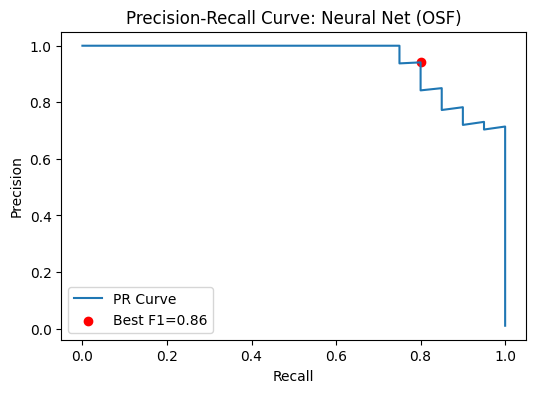

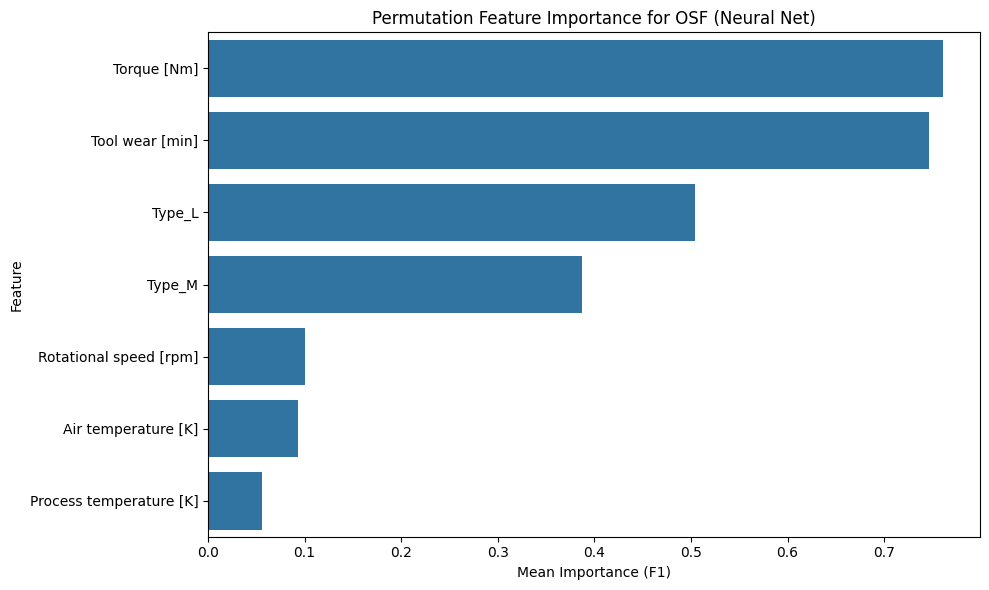


=== Neural Net Analysis for RNF ===
Best Params: {'alpha': 0.0001, 'hidden_layer_sizes': (32,), 'learning_rate_init': 0.001, 'max_iter': 200}
Best Threshold: 0.001, F1: 0.005, Precision: 0.002, Recall: 0.750
Best Params: {'alpha': 0.0001, 'hidden_layer_sizes': (32,), 'learning_rate_init': 0.001, 'max_iter': 200}
Best Threshold: 0.001, F1: 0.005, Precision: 0.002, Recall: 0.750


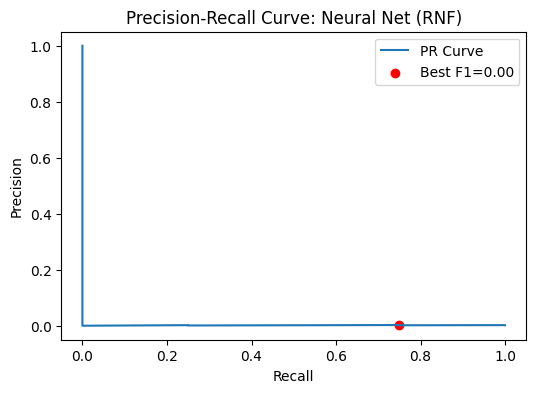

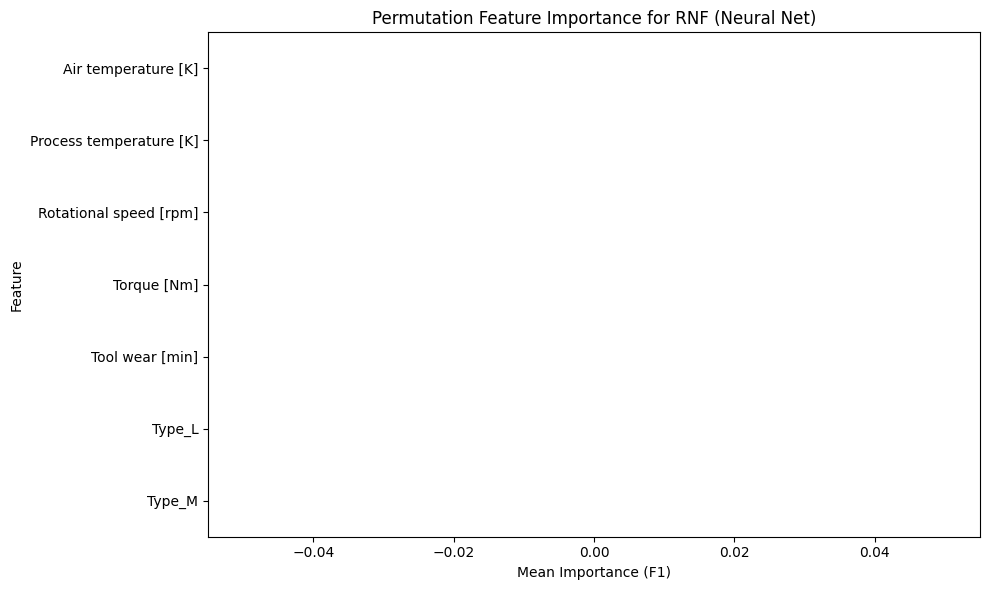

In [4]:
# Neural Net Training, Evaluation, and Permutation Feature Importance

FAILURE_TYPES = ['Machine failure', 'TWF', 'HDF', 'PWF', 'OSF', 'RNF']
mlp_param_grid = {
    'hidden_layer_sizes': [(32,), (64,), (32,16), (64,32)],
    'alpha': [0.0001, 0.001, 0.01],
    'learning_rate_init': [0.001, 0.01],
    'max_iter': [200]
}

for failure in FAILURE_TYPES:
    print(f'\n=== Neural Net Analysis for {failure} ===')
    X = df_clean.drop(FAILURE_TYPES, axis=1)
    # Drop any bin/interval columns
    X = X.loc[:, ~X.columns.str.contains('Bin', case=False)]
    for col in X.columns:
        if pd.api.types.is_interval_dtype(X[col]):
            X = X.drop(columns=[col])
    y = df_clean[failure]
    X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    mlp = MLPClassifier(random_state=42)
    grid = GridSearchCV(mlp, mlp_param_grid, scoring='f1', cv=3, n_jobs=-1)
    grid.fit(X_train_scaled, y_train)
    best_mlp = grid.best_estimator_
    y_proba = best_mlp.predict_proba(X_test_scaled)[:,1]
    # Find best threshold for F1-score
    precisions, recalls, thresholds = precision_recall_curve(y_test, y_proba)
    f1s = 2 * (precisions * recalls) / (precisions + recalls + 1e-8)
    best_idx = np.argmax(f1s)
    best_thresh = thresholds[best_idx]
    best_f1 = f1s[best_idx]
    best_prec = precisions[best_idx]
    best_rec = recalls[best_idx]
    print(f'Best Params: {grid.best_params_}')
    print(f'Best Threshold: {best_thresh:.3f}, F1: {best_f1:.3f}, Precision: {best_prec:.3f}, Recall: {best_rec:.3f}')
    # Plot precision-recall curve
    plt.figure(figsize=(6,4))
    plt.plot(recalls, precisions, label='PR Curve')
    plt.scatter([best_rec], [best_prec], color='red', label=f'Best F1={best_f1:.2f}')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'Precision-Recall Curve: Neural Net ({failure})')
    plt.legend()
    plt.show()
    # Permutation feature importance
    result = permutation_importance(best_mlp, X_test_scaled, y_test, n_repeats=10, random_state=42, scoring='f1')
    importances = pd.Series(result.importances_mean, index=X.columns).sort_values(ascending=False)
    plt.figure(figsize=(10,6))
    sns.barplot(x=importances.values, y=importances.index)
    plt.title(f'Permutation Feature Importance for {failure} (Neural Net)')
    plt.xlabel('Mean Importance (F1)')
    plt.ylabel('Feature')
    plt.tight_layout()
    plt.show()


=== Model Comparison for Machine failure ===

=== Model Comparison for TWF ===

=== Model Comparison for HDF ===

=== Model Comparison for PWF ===

=== Model Comparison for OSF ===

=== Model Comparison for RNF ===


,Failure Type,Model,Best Threshold,F1 (Best Thresh),Precision (Best Thresh),Recall (Best Thresh)
0,Machine failure,Neural Net,0.265111,0.657718,0.604938,0.720588
1,Machine failure,Logistic Regression,0.208521,0.500000,0.486111,0.514706
2,Machine failure,Decision Tree,1.000000,0.671756,0.698413,0.647059
3,Machine failure,Random Forest,0.390000,0.793651,0.862069,0.735294
4,TWF,Neural Net,0.044050,0.150943,0.090909,0.444444
5,TWF,Logistic Regression,0.090245,0.230769,0.176471,0.333333
6,TWF,Decision Tree,1.000000,0.111111,0.111111,0.111111
7,TWF,Random Forest,0.030000,0.108108,0.058824,0.666667
8,HDF,Neural Net,0.282215,0.723404,0.708333,0.739130
9,HDF,Logistic Regression,0.146217,0.714286,0.606061,0.869565


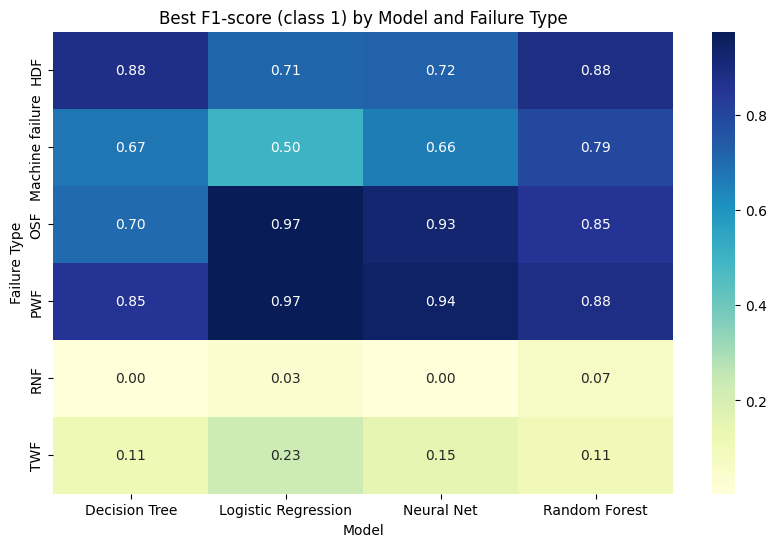

In [3]:
# Compare Neural Net with Logistic Regression, Decision Tree, and Random Forest
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

model_dict = {
    'Neural Net': MLPClassifier(random_state=42, **grid.best_params_),
    'Logistic Regression': LogisticRegression(solver='liblinear', max_iter=1000),
    'Decision Tree': DecisionTreeClassifier(),
    'Random Forest': RandomForestClassifier()
}

summary = []
for failure in FAILURE_TYPES:
    print(f'\n=== Model Comparison for {failure} ===')
    X = df_clean.drop(FAILURE_TYPES, axis=1)
    X = X.loc[:, ~X.columns.str.contains('Bin', case=False)]
    for col in X.columns:
        if pd.api.types.is_interval_dtype(X[col]):
            X = X.drop(columns=[col])
    y = df_clean[failure]
    X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    for name, model in model_dict.items():
        if name == 'Neural Net':
            model.fit(X_train_scaled, y_train)
            y_proba = model.predict_proba(X_test_scaled)[:,1]
        else:
            model.fit(X_train, y_train)
            y_proba = model.predict_proba(X_test)[:,1] if hasattr(model, 'predict_proba') else model.decision_function(X_test)
            if not hasattr(model, 'predict_proba'):
                y_proba = (y_proba - y_proba.min()) / (y_proba.max() - y_proba.min())
        precisions, recalls, thresholds = precision_recall_curve(y_test, y_proba)
        f1s = 2 * (precisions * recalls) / (precisions + recalls + 1e-8)
        best_idx = np.argmax(f1s)
        best_thresh = thresholds[best_idx]
        best_f1 = f1s[best_idx]
        best_prec = precisions[best_idx]
        best_rec = recalls[best_idx]
        summary.append({
            'Failure Type': failure,
            'Model': name,
            'Best Threshold': best_thresh,
            'F1 (Best Thresh)': best_f1,
            'Precision (Best Thresh)': best_prec,
            'Recall (Best Thresh)': best_rec
        })

summary_df = pd.DataFrame(summary)
display(summary_df)

# Visualize F1-score comparison
pivot_f1 = summary_df.pivot(index='Failure Type', columns='Model', values='F1 (Best Thresh)')
plt.figure(figsize=(10,6))
sns.heatmap(pivot_f1, annot=True, fmt='.2f', cmap='YlGnBu')
plt.title('Best F1-score (class 1) by Model and Failure Type')
plt.show()